# Task 2: Experimentation and uplift testing

1. Select control stores – explore the data and define metrics for control store selection.

2. Assessment of the trial – check each trial store individually in comparison with the control store to get a clear view of its overall performance. 

3. Collate findings – summarise findings for each store and provide an recommendation that we can share with Julia outlining the impact on sales during the trial period.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, t

In [2]:
qvi = pd.read_csv("QVI_data.csv")
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
## check for nulls and posible outliers
qvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
## Create a column for yermonth
qvi["DATE"] = pd.to_datetime(qvi["DATE"])
qvi["YEARMONTH"] = qvi["DATE"].dt.strftime("%Y%m").astype("int")
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


## Selecting control store
Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

Consider the monthly sales experience of each store. This can be broken down by:

- total sales revenue
- total number of customers
- average number of transactions per customer



In [5]:
def monthly_store_metrics():
    store_yrmo_group = qvi.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique() ##numbers of unique value
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [6]:
qvi_monthly_metrics = monthly_store_metrics().reset_index()
qvi_monthly_metrics

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,2.022222,4.346154
3165,272,201903,442.3,50,1.060000,2.020000,4.379208
3166,272,201904,445.1,54,1.037037,1.944444,4.239048
3167,272,201905,314.6,34,1.176471,2.088235,4.430986


In [7]:
## Filter to the pre‐trial period(201807-201901) and stores with full observation periods
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts() ##calc each store that has 12 month data
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902][['STORE_NBR','YEARMONTH','TOT_SALES','nCustomers','nTxnPerCust']]
pretrial_full_observ

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000
3160,272,201810,430.6,44,1.159091
3161,272,201811,376.2,41,1.097561
3162,272,201812,403.9,47,1.000000


Combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver. 
if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

In [8]:
## Create a function to calculate correlation for a measure looping through each control store
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
  control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
  corrs = pd.DataFrame(columns = ["Trial_Str", "Ctrl_Str", "Corr_Score"])
  trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index().drop(columns=['index'])
  for control in control_store_nbrs:
    concat_df = pd.DataFrame(columns = ["Trial_Str", "Ctrl_Str", "Corr_Score"])
    control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index().drop(columns=['index'])
    concat_df["Corr_Score"] = trial_store.corrwith(control_store)
    concat_df["Trial_Str"] = storeComparison
    concat_df["Ctrl_Str"] = control
    corrs = pd.concat([corrs, concat_df])
  return corrs

In [9]:
##Create a function to calculate standardised magnitude distance for a measure looping through each control store
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists

In [10]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists= dists.groupby(["Trial_Str", "Ctrl_Str"])['magnitude'].mean().reset_index()
    combine = pd.merge(corrs, dists, on=["Trial_Str", "Ctrl_Str"])
    return combine

We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

In [11]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [12]:
metricCol=["TOT_SALES"]
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(metricCol, trial_num)])
## compare_metrics_table1.drop(metricCol, axis=1, inplace= True)      
compare_metrics_table1["CompScore1"] = (0.5 * compare_metrics_table1["Corr_Score"]) + (0.5 * compare_metrics_table1["magnitude"])
compare_metrics_table1

,Trial_Str,Ctrl_Str,Corr_Score,magnitude,CompScore1
0,77,1,0.075218,0.956978,0.516098
1,77,2,-0.263079,0.941464,0.339193
2,77,3,0.806644,0.402104,0.604374
3,77,4,-0.2633,0.237849,-0.012725
4,77,5,-0.110652,0.585403,0.237376
...,...,...,...,...,...
252,88,268,-0.021429,0.206901,0.092736
253,88,269,-0.172578,0.724743,0.276083
254,88,270,-0.723272,0.728129,0.002429
255,88,271,-0.103037,0.633696,0.265329


Determining the top five highest composite score for each trial based on Total sales

In [13]:
print("Top five highest composite score for each trial based on Total sales",'\n')
for trial_num in [77,86,88]:
    print(compare_metrics_table1[compare_metrics_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore1").head(3), '\n')

Top five highest composite score for each trial based on Total sales 

    Trial_Str Ctrl_Str Corr_Score  magnitude CompScore1
218        77      233   0.903774   0.986477   0.945125
38         77       41   0.783232   0.967433   0.875332
46         77       50   0.763866   0.975067   0.869466 

    Trial_Str Ctrl_Str Corr_Score  magnitude CompScore1
144        86      155   0.877882   0.965876   0.921879
207        86      222   0.795075   0.962280   0.878678
99         86      109     0.7883   0.966783   0.877541 

    Trial_Str Ctrl_Str Corr_Score  magnitude CompScore1
114        88      125   0.624109   0.860721   0.742415
191        88      203   0.508001   0.953160   0.730581
82         88       91   0.776688   0.680758   0.728723 



**Determining the top five highest composite score for each trial based on no. of customers**

In [14]:
metricCol=["nCustomers"]
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(metricCol, trial_num)])     
compare_metrics_table2["CompScore2"] = (0.5 * compare_metrics_table2["Corr_Score"]) + (0.5 * compare_metrics_table2["magnitude"])
print("Top five highest composite score for each trial based on Total sales",'\n')
for trial_num in [77,86,88]:
    print(compare_metrics_table2[compare_metrics_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore2").head(3), '\n')

Top five highest composite score for each trial based on Total sales 

    Trial_Str Ctrl_Str Corr_Score  magnitude CompScore2
218        77      233   0.990358   0.993132   0.991745
238        77      254   0.916208   0.940934   0.928571
38         77       41   0.844219   0.976648   0.910434 

    Trial_Str Ctrl_Str Corr_Score  magnitude CompScore2
144        86      155   0.942876   0.986772   0.964824
104        86      114   0.855339   0.941799   0.898569
99         86      109   0.770778   0.969577   0.870177 

    Trial_Str Ctrl_Str Corr_Score  magnitude CompScore2
222        88      237   0.947326   0.987818   0.967572
167        88      178   0.939466   0.828350   0.883908
65         88       69   0.815792   0.874862   0.845327 



**Considering two factors of total sales and numbers of customers, we evaluate a avg value.**

In [15]:
compr = pd.merge(compare_metrics_table1,compare_metrics_table2, on=["Trial_Str", "Ctrl_Str"])
compr['AvgScore']=(0.4*compr['CompScore1']+0.6*compr['CompScore2'])
for trial_num in [77, 86, 88]:
    top3= compr[compr["Trial_Str"] == trial_num].sort_values(ascending=False,by="AvgScore").head(3).set_index(["Trial_Str", "Ctrl_Str"])["AvgScore"]
    print(top3, '\n')

Trial_Str  Ctrl_Str
77         233         0.973097
           41          0.896393
           17           0.86007
Name: AvgScore, dtype: object 

Trial_Str  Ctrl_Str
86         155         0.947646
           109         0.873123
           114         0.871523
Name: AvgScore, dtype: object 

Trial_Str  Ctrl_Str
88         237         0.833959
           178         0.819235
           69          0.742004
Name: AvgScore, dtype: object 



Similarities based on Highest average of total saleS and No. of Customers:
1. Trial store 77: Store 233
2. Trial store 86: Store 155
3. Trial store 88: Store 237


## Assessment of the trial
**Visualize the performance to compare trial and control store Trial. Based on the insight we conclude whether the trial store is successful or not.**


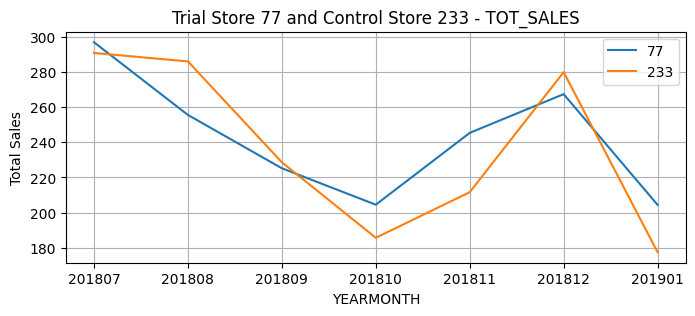

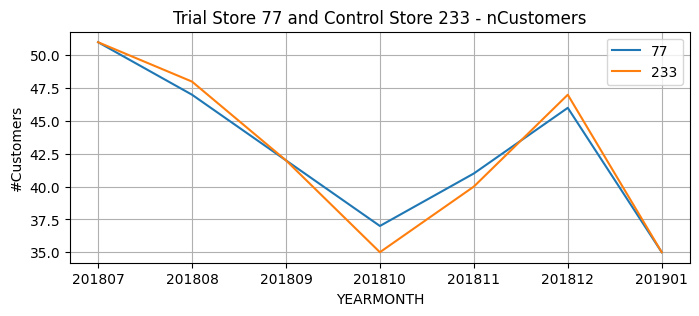

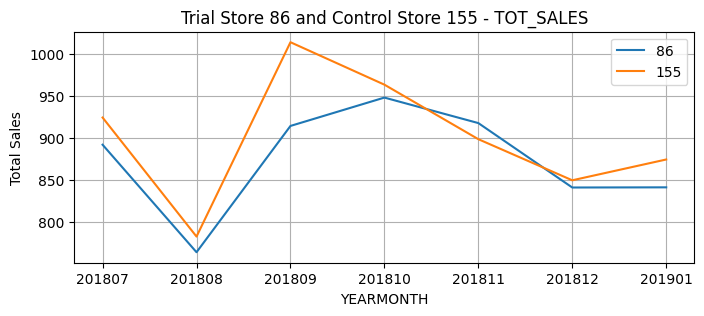

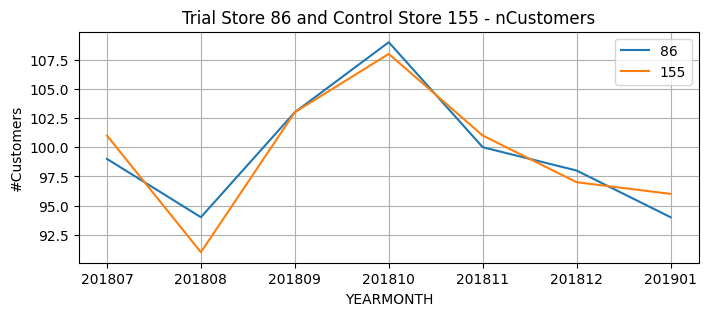

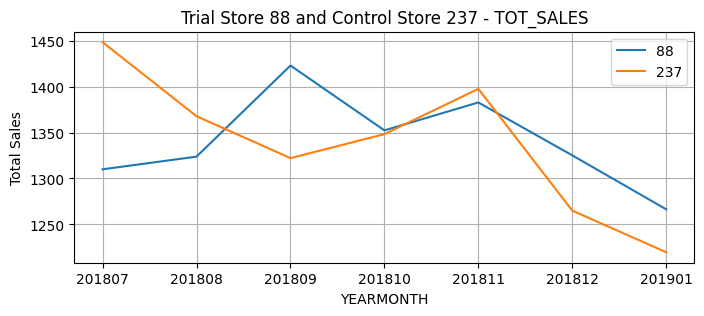

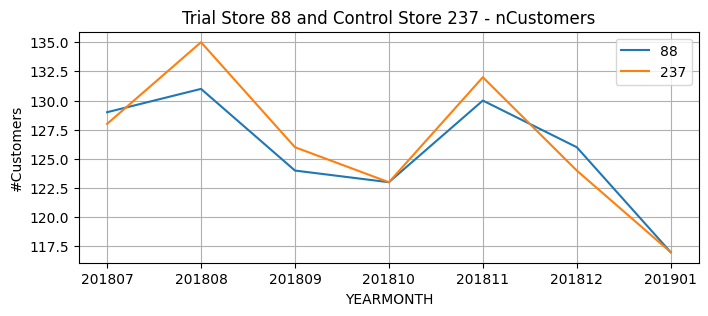

In [16]:
##The performance of Trial stores to Control stores during pretrial period.
trial_control_dic = {77:233, 86:155, 88:237}
for key, val in trial_control_dic.items():
    #a:trial store b:control store 
    a = pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].reset_index(level=1, drop=True)
    ## a.index = pd.to_datetime(a.index, format='%Y%m')
    a.index = a.index.astype(str) #set yearmonth index to str type to better show on plot 
    b = pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].reset_index(level=1, drop=True)
    b.index = b.index.astype(str)                    
    plt.figure(figsize = (8,3))
    a.plot()
    b.plot()
    plt.legend(labels = [str(key),str(val),'other'])
    plt.grid(which='both')
    plt.ylabel('Total Sales')
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - TOT_SALES")
    
    
    ## nCustomer
    a = pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].reset_index(level=1, drop=True)
    a.index = a.index.astype(str)
    b = pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].reset_index(level=1, drop=True)
    b.index = b.index.astype(str)
    plt.figure(figsize = (8,3))
    a.plot()
    b.plot()
    plt.legend(labels = [str(key),str(val),'other'])
    plt.grid(which='both')
    plt.ylabel('#Customers')
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - nCustomers")
    
    
    

To compare the performance of Trial stores to Control stores during the trial period, will scale (multiply to ratio of trial / control) all of Control stores' performance to Trial store's performance during pre-trial.

In [17]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
#Ratio of Store 77 and its Control store.
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 88 and its Control store.
sales_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 237]["TOT_SALES"].sum()




In [18]:
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 237])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 237:
        return row["TOT_SALES"] * sales_ratio_88
## Apply the scaling factor for control store
scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)
scaled_sales_control_stores.rename(columns = {'STORE_NBR':'c_STORE_NBR'}, inplace = True)

diff_metrics = pd.DataFrame()
for trial, control in trial_control_dic.items():
    ctrl = scaled_sales_control_stores[scaled_sales_control_stores["c_STORE_NBR"] == control]
    tral = full_observ[full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH","TOT_SALES"]]
    diff_table= tral.merge(ctrl[["YEARMONTH",'c_STORE_NBR', "ScaledSales"]],on="YEARMONTH").rename(columns={"STORE_NBR":"t_STORE_NBR", "ScaledSales":"Scaled_Control_Sales", "TOT_SALES":"Trial_Sales"})
    diff_table['Sales_Percentage_Diff']= abs((diff_table.Scaled_Control_Sales-diff_table.Trial_Sales)/diff_table.Scaled_Control_Sales)
    diff_metrics=pd.concat([diff_metrics,diff_table])

def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
diff_metrics["Trial_period"] = diff_metrics["YEARMONTH"].apply(lambda cell: label_period(cell))
diff_metrics.head(3)

,t_STORE_NBR,YEARMONTH,Trial_Sales,c_STORE_NBR,Scaled_Control_Sales,Sales_Percentage_Diff,Trial_period
0,77,201807,296.8,233,297.565550,0.002573,pre
1,77,201808,255.5,233,292.652187,0.126950,pre
2,77,201809,225.2,233,233.998916,0.037602,pre


**Null hypothesis is that the trial period is the same as the pretrial period, 
check the standard deviation based on the scaledpercentage difference in the pre‐trial period**

In [19]:
stdDev= diff_metrics.groupby(['t_STORE_NBR','Trial_period'])["Sales_Percentage_Diff"].std().reset_index()
stdDev.rename(columns={'Sales_Percentage_Diff':'std_value'}, inplace = True)
pre_stdDev=stdDev[stdDev["Trial_period"]=="pre"]
pre_stdDev

,t_STORE_NBR,Trial_period,std_value
1,77,pre,0.049941
4,86,pre,0.025834
7,88,pre,0.033468


In [20]:
#Degree of freedom = n_pre_trial -1
dof = 7 -1
crt_t = t.ppf(0.95, dof)
print('Critical t value is: {}'.format(crt_t))

Critical t value is: 1.9431802803927818


In [21]:
def Assessment(trial):
    crt_t = t.ppf(0.95, dof)
    check_trial= diff_metrics[diff_metrics['t_STORE_NBR']==trial]
    pre_stdDev= check_trial[check_trial['Trial_period']=='pre']["Sales_Percentage_Diff"].std().astype(float)
    check_trial["t-Score"] = (check_trial["Sales_Percentage_Diff"]-0)/pre_stdDev
    check_trial['95%CI'] = check_trial['Scaled_Control_Sales']*(1+crt_t*pre_stdDev)
    check_trial['5%CI'] = check_trial['Scaled_Control_Sales']*(1-crt_t*pre_stdDev)
    return check_trial
    

In [22]:
check_77=Assessment(77)
check_77_trial= check_77[check_77["Trial_period"]=="trial"][['t_STORE_NBR','YEARMONTH', 't-Score']]
print(check_77_trial)
print('Critical t is: {}'.format(crt_t))

   t_STORE_NBR  YEARMONTH    t-Score
7           77     201902   1.183534
8           77     201903   7.339116
9           77     201904  12.476373
Critical t is: 1.9431802803927818


C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_trial["t-Score"] = (check_trial["Sales_Percentage_Diff"]-0)/pre_stdDev
C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_trial['95%CI'] = check_trial['Scaled_Control_Sales']*(1+crt_t*pre_stdDev)
C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

The t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.

### Trial 77 Control 233

In [23]:
check_77

,t_STORE_NBR,YEARMONTH,Trial_Sales,c_STORE_NBR,Scaled_Control_Sales,Sales_Percentage_Diff,Trial_period,t-Score,95%CI,5%CI
0,77,201807,296.8,233,297.565550,0.002573,pre,0.051515,326.442473,268.688627
1,77,201808,255.5,233,292.652187,0.126950,pre,2.542011,321.052298,264.252076
2,77,201809,225.2,233,233.998916,0.037602,pre,0.752940,256.707084,211.290747
3,77,201810,204.5,233,190.085733,0.075830,pre,1.518406,208.532395,171.639071
4,77,201811,245.3,233,216.597421,0.132516,pre,2.653459,237.616881,195.577962
5,77,201812,267.3,233,286.408121,0.066716,pre,1.335911,314.202284,258.613959
6,77,201901,204.4,233,181.692071,0.124980,pre,2.502571,199.324179,164.059963
7,77,201902,235.0,233,249.762622,0.059107,trial,1.183534,274.000562,225.524682
8,77,201903,278.5,233,203.802205,0.366521,trial,7.339116,223.579967,184.024443
9,77,201904,263.5,233,162.345704,0.623080,trial,12.476373,178.100365,146.591043


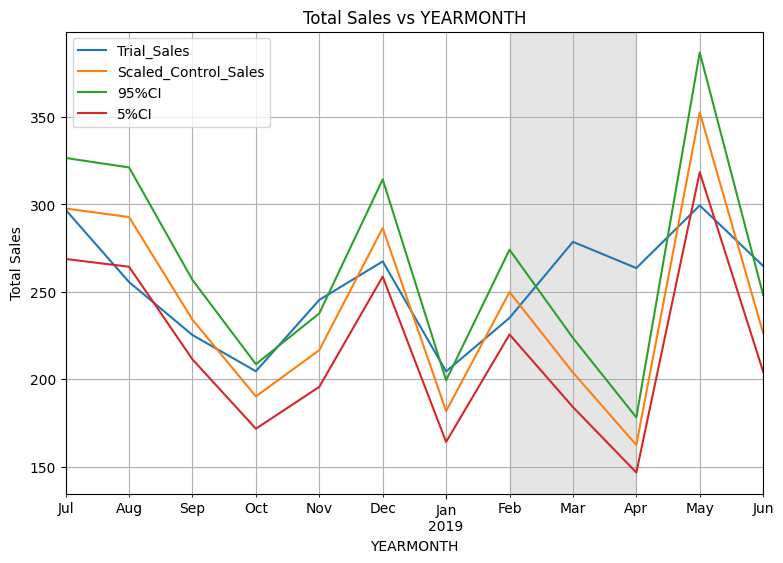

In [24]:
plot_77 = pd.DataFrame(check_77)
plot_77 = plot_77.drop(columns = ['t_STORE_NBR','c_STORE_NBR','Sales_Percentage_Diff','t-Score'])
plot_77['YEARMONTH'] = pd.to_datetime(plot_77['YEARMONTH'], format='%Y%m', errors='coerce')
plot_77 = plot_77.set_index('YEARMONTH')
##plot_77.index= plot_77.index.astype(str)

#The shaded area is the trial period
plot_77.plot(legend = True,figsize=(9,6))
#ax.set_xticks(range(plot_77.index.size))
#ax.set_xticklabels(plot_77.index)
plt.axvspan("2019-02-01","2019-04-01",color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.ylabel('Total Sales')
plt.title('Total Sales vs YEARMONTH',size=12)
plt.grid(which='both')
plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

Text(0.5, 1.0, 'Total Sales vs Yearmonth')

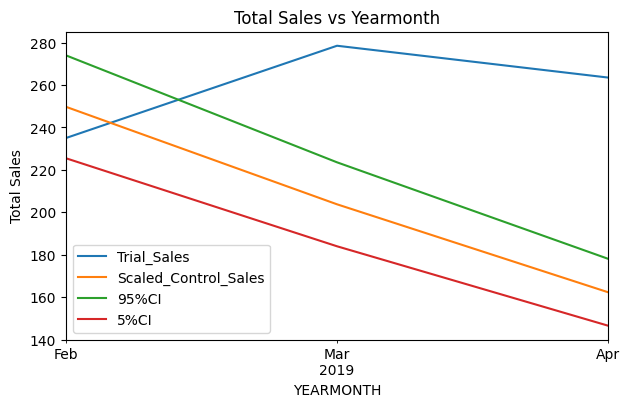

In [25]:
#Zoom-in for just the trial period
plot_77.iloc[(plot_77.index >= "2019-02-01") & (plot_77.index <= "2019-04-01"),:].plot(legend = True, figsize=(7,4))
plt.ylabel('Total Sales')
plt.title('Total Sales vs Yearmonth',size=12)
plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

### Findings:
The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.

### Trial 86 Control 155

In [26]:
check_86=Assessment(86)
check_86_trial= check_86[check_86["Trial_period"]=="trial"][['t_STORE_NBR','YEARMONTH', 't-Score']]
print(check_86_trial)
print('Critical t is: {}'.format(crt_t))



   t_STORE_NBR  YEARMONTH    t-Score
7           86     201902   2.179542
8           86     201903  12.226922
9           86     201904   1.364580
Critical t is: 1.9431802803927818


C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_trial["t-Score"] = (check_trial["Sales_Percentage_Diff"]-0)/pre_stdDev
C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_trial['95%CI'] = check_trial['Scaled_Control_Sales']*(1+crt_t*pre_stdDev)
C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

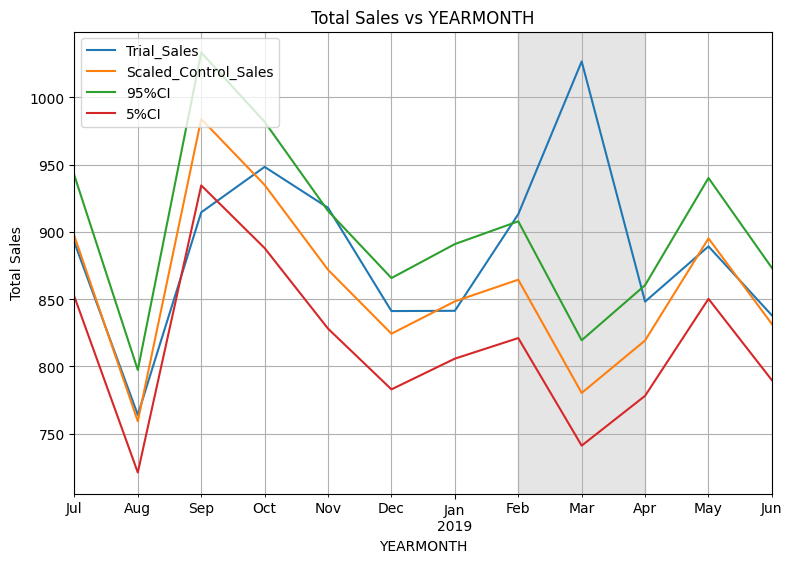

In [27]:
plot_86 = pd.DataFrame(check_86)
plot_86 = plot_86.drop(columns = ['t_STORE_NBR','c_STORE_NBR','Sales_Percentage_Diff','t-Score'])
plot_86['YEARMONTH'] = pd.to_datetime(plot_86['YEARMONTH'], format='%Y%m', errors='coerce')
plot_86 = plot_86.set_index('YEARMONTH')

#The shaded area is the trial period
plot_86.plot(legend = True,figsize=(9,6))
plt.axvspan("2019-02-01","2019-04-01",color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.ylabel('Total Sales')
plt.title('Total Sales vs YEARMONTH',size=12)
plt.grid(which='both')
plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

Text(0.5, 1.0, 'Total Sales vs Yearmonth')

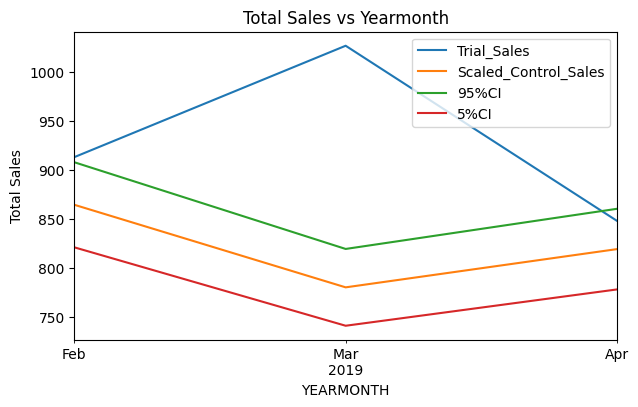

In [28]:
#Zoom-in for just the trial period
plot_86.iloc[(plot_86.index >= "2019-02-01") & (plot_86.index <= "2019-04-01"),:].plot(legend = True, figsize=(7,4))
plt.ylabel('Total Sales')
plt.title('Total Sales vs Yearmonth',size=12)
plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

### Findings:
The trial in store 86 is lightly significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.

### Trial 88 Control 237

In [29]:
check_88=Assessment(88)
check_88_trial= check_88[check_88["Trial_period"]=="trial"][['t_STORE_NBR','YEARMONTH', 't-Score']]
print(check_88_trial)
print('Critical t is: {}'.format(crt_t))

   t_STORE_NBR  YEARMONTH   t-Score
7           88     201902  0.781270
8           88     201903  6.595668
9           88     201904  5.768527
Critical t is: 1.9431802803927818


C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_trial["t-Score"] = (check_trial["Sales_Percentage_Diff"]-0)/pre_stdDev
C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_trial['95%CI'] = check_trial['Scaled_Control_Sales']*(1+crt_t*pre_stdDev)
C:\Users\chelsea\AppData\Local\Temp\ipykernel_18692\4005313736.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

In [30]:
check_88

,t_STORE_NBR,YEARMONTH,Trial_Sales,c_STORE_NBR,Scaled_Control_Sales,Sales_Percentage_Diff,Trial_period,t-Score,95%CI,5%CI
0,88,201807,1310.00,237,1450.657086,0.096961,pre,2.897136,1544.999264,1356.314908
1,88,201808,1323.80,237,1369.931485,0.033674,pre,1.006168,1459.023746,1280.839224
2,88,201809,1423.00,237,1324.260425,0.074562,pre,2.227870,1410.382509,1238.138340
3,88,201810,1352.40,237,1350.401097,0.001480,pre,0.044228,1438.223217,1262.578978
4,88,201811,1382.80,237,1399.777923,0.012129,pre,0.362408,1490.811220,1308.744626
5,88,201812,1325.20,237,1266.971288,0.045959,pre,1.373227,1349.367625,1184.574951
6,88,201901,1266.40,237,1221.600696,0.036673,pre,1.095756,1301.046397,1142.154994
7,88,201902,1370.20,237,1406.989143,0.026147,trial,0.781270,1498.491415,1315.486871
8,88,201903,1477.20,237,1210.082775,0.220743,trial,6.595668,1288.779419,1131.386131
9,88,201904,1439.40,237,1206.477165,0.193060,trial,5.768527,1284.939321,1128.015009


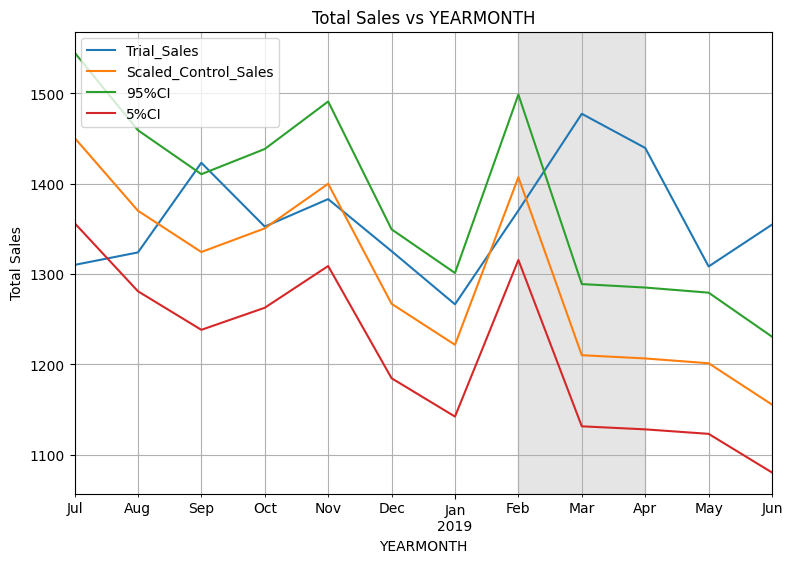

In [31]:
plot_88 = pd.DataFrame(check_88)
plot_88 = plot_88.drop(columns = ['t_STORE_NBR','c_STORE_NBR','Sales_Percentage_Diff','t-Score'])
plot_88['YEARMONTH'] = pd.to_datetime(plot_88['YEARMONTH'], format='%Y%m', errors='coerce')
plot_88 = plot_88.set_index('YEARMONTH')

#The shaded area is the trial period
plot_88.plot(legend = True,figsize=(9,6))
plt.axvspan("2019-02-01","2019-04-01",color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.ylabel('Total Sales')
plt.title('Total Sales vs YEARMONTH',size=12)
plt.grid(which='both')
plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

Text(0.5, 1.0, 'Total Sales vs Yearmonth')

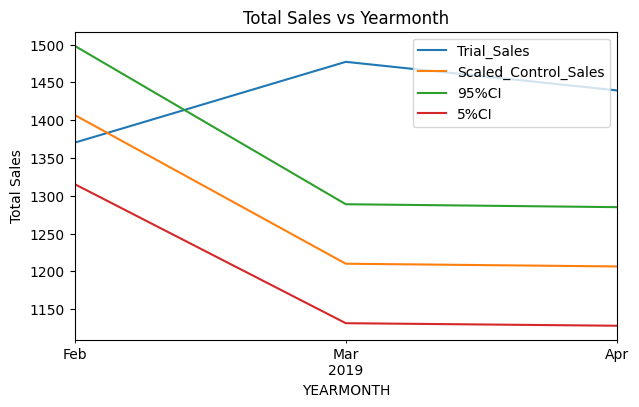

In [32]:
#Zoom-in for just the trial period
plot_88.iloc[(plot_88.index >= "2019-02-01") & (plot_88.index <= "2019-04-01"),:].plot(legend = True, figsize=(7,4))
plt.ylabel('Total Sales')
plt.title('Total Sales vs Yearmonth',size=12)
plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

### Findings:
Total number of customers in the trial period for the trial store is significantly higher than the control store
for two out of three months, which indicates a positive trial effect.

### Conclusion:
1. Control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
2. The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86, but overall, the trial shows a significant increase in sales. 